## Python imports

In [1]:
import scipy as sp
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.spatial import ConvexHull
import scipy.optimize

from ipywidgets import interact, Checkbox

%matplotlib inline
plt.style.use("ggplot")

## Rate constants for van de Vusse kinetics

In [2]:
k1 = 1.0
k2 = 1.0
k3 = 10.0

## Define 2D van de Vusse rate function

In [3]:
#2D van de Vusse kinetics
#A -> B -> C

def rate_fn(C,t):
    cA = C[0]
    cB = C[1]

    #r = [rA, rB]
    return sp.array([-k1*cA - 2*k3*cA**2,
                    k1*cA - k2*cB])

## Feed point

In [4]:
Cf = sp.array([1., 0.])

## Integrate PFR

In [5]:
t_end = 10;
N_pts = 50;
pfr_ts = sp.logspace(-3,sp.log10(t_end),N_pts)

pfr_cs = odeint(rate_fn,Cf,pfr_ts)

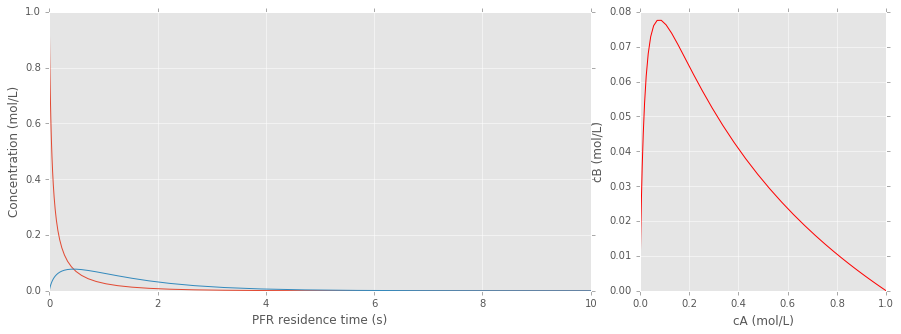

In [6]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,(1,2))
plt.hold(True)

plt.plot(pfr_ts,pfr_cs[:,0])
plt.plot(pfr_ts,pfr_cs[:,1])

plt.xlabel('PFR residence time (s)')
plt.ylabel('Concentration (mol/L)')

plt.subplot(1,3,3)
plt.plot(pfr_cs[:,0],pfr_cs[:,1], 'r-')

plt.xlabel('cA (mol/L)')
plt.ylabel('cB (mol/L)')
plt.show()

plt.show()

## Solve CSTR locus

In [7]:
cstr_ts = sp.logspace(-3,sp.log10(t_end*100),N_pts)

k=0
C_guess = Cf
cstr_cs = Cf
for ti in cstr_ts:
    def cstr_fn(Ci):
        f = Cf + ti*rate_fn(Ci,[]) - Ci
        
        return f
    
    #attempt to solve for CSTR solution
    Ci = scipy.optimize.newton_krylov(cstr_fn, C_guess, f_tol=1e-4)
    cstr_cs = sp.vstack([cstr_cs, Ci])
    C_guess = Ci
    
    k += 1

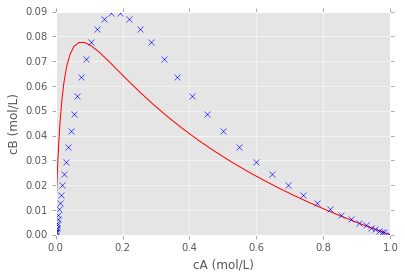

In [8]:
plt.figure()
plt.hold(True)

plt.plot(pfr_cs[:,0],pfr_cs[:,1], 'r-')
plt.plot(cstr_cs[:,0],cstr_cs[:,1], 'bx')

plt.xlabel('cA (mol/L)')
plt.ylabel('cB (mol/L)')

plt.show()

## Plot PFR trajectories from CSTR points

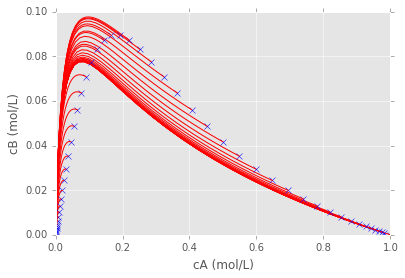

In [9]:
all_cs = cstr_cs

plt.figure()
plt.hold(True)

for ci in cstr_cs:
    pi_cs = odeint(rate_fn,ci,pfr_ts)
    
    plt.plot(ci[0],ci[1], 'bx')
    plt.plot(pi_cs[:,0],pi_cs[:,1],'r-')
    
    all_cs = sp.vstack([all_cs, pi_cs])
    
plt.xlabel('cA (mol/L)')
plt.ylabel('cB (mol/L)')

plt.show()

## Convex hull

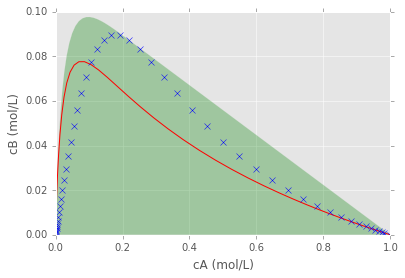

In [10]:
K = ConvexHull(all_cs).vertices
chull_xs, chull_ys = all_cs[K,0], all_cs[K,1]
    
plt.figure()
plt.hold(True)

plt.fill(chull_xs, chull_ys, 'g', alpha=0.3)
plt.plot(pfr_cs[:,0],pfr_cs[:,1],'r-')
plt.plot(cstr_cs[:,0],cstr_cs[:,1], 'bx')

plt.xlabel('cA (mol/L)')
plt.ylabel('cB (mol/L)')

plt.show()

## Objective function 1

In [11]:
def plot_fn2(m=0.25, cB=0.15):
      
    def objective_fn(cA):
        return cA*m + cB
    
    obj_cAs = sp.linspace(0,1,10)
    obj_cBs = objective_fn(obj_cAs)
    
    plt.figure()
    plt.hold(True)

    plt.fill(chull_xs, chull_ys, 'g', alpha=0.3)
    plt.plot(pfr_cs[:,0],pfr_cs[:,1],'r-')
    plt.plot(cstr_cs[:,0],cstr_cs[:,1], 'bx')
    
    plt.plot(obj_cAs,obj_cBs,'k:')

    plt.title('cB = %.2fcA + %.3f mol/L'%(m,cB))
    plt.axis([0,1, 0,0.3])
    plt.xlabel('cA (mol/L)')
    plt.ylabel('cB (mol/L)')
    plt.show()

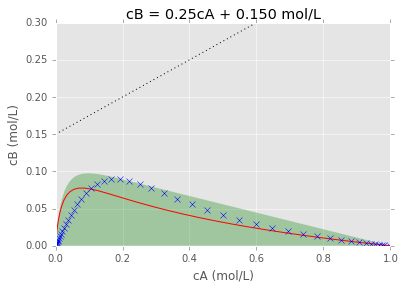

<function __main__.plot_fn2>

In [12]:
interact(plot_fn2, m=(0,1,0.02), cB=(0,0.3,0.005))

## Alternate objective function

In chapter 4, we use instantaneous yield of component B over component D as an objective function.

$$Y_{BD} = \frac{k_1c_A - k_2c_B}{k_3{c_A}^2}$$

When plotted against the AR, this provides insight into which concentrations should be targeted to favour the production of either component B or D.

In [13]:
def plot_fn3(Y_BD=0.1):
      
    def objective_fn(cA):
        return (k1*cA - Y_BD*k3*cA**2)/k2
    
    obj_cAs = sp.linspace(0,1,50)
    obj_cBs = objective_fn(obj_cAs)
    
    plt.figure()
    plt.hold(True)

    plt.fill(chull_xs, chull_ys, 'g', alpha=0.3)
    plt.plot(pfr_cs[:,0],pfr_cs[:,1],'r-')
    plt.plot(cstr_cs[:,0],cstr_cs[:,1], 'bx')
    
    plt.plot(obj_cAs,obj_cBs,'k:')

    plt.title('Yield $Y_{BD}$ = %.3f'%(Y_BD))
    plt.axis([0,1, 0,0.3])
    plt.xlabel('cA (mol/L)')
    plt.ylabel('cB (mol/L)')
    plt.show()

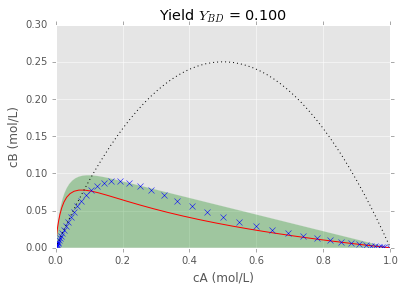

<function __main__.plot_fn3>

In [14]:
interact(plot_fn3, Y_BD=(0,0.5,0.001))